# Data Visualization - Notebook 2
## Exploring Dataset Characteristics

- Image size distribution
- Class label distribution
- Sample images from each class


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from pathlib import Path
from tqdm import tqdm
import random

In [2]:
# Seting matplotlib style
plt.style.use('ggplot')

# Paths
projectRoot = Path().resolve().parent
datasetPath = projectRoot / "CV2024_CW_Dataset"

trainImagePath = datasetPath / "train" / "images"
trainLabelPath = datasetPath / "train" / "labels"
testImagePath = datasetPath / "test" / "images"
testLabelPath = datasetPath / "test" / "labels"

trainImages = sorted(os.listdir(trainImagePath))
testImages = sorted(os.listdir(testImagePath))

print("Dataset paths set up correctly.")

Dataset paths set up correctly.


## Image Size Distribution/Analysis


Extracting image sizes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 458/458 [00:00<00:00, 9263.01it/s]


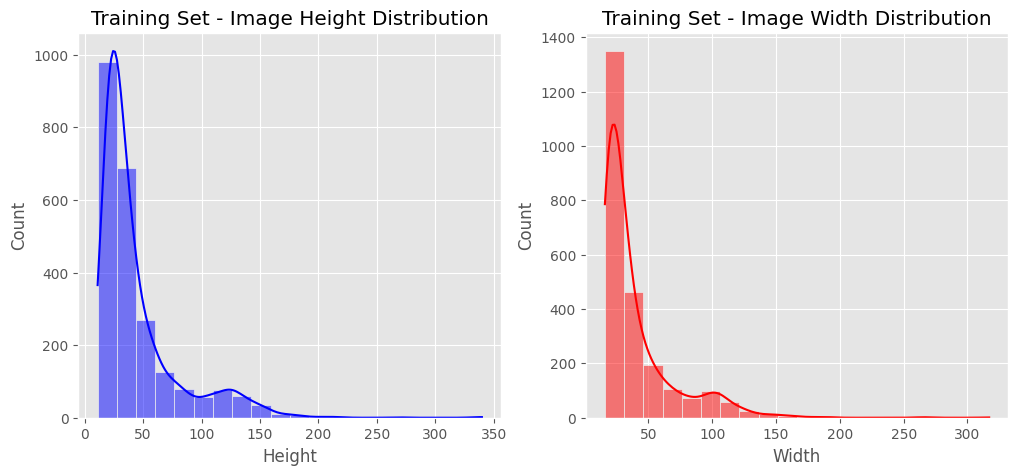

In [3]:
def getImageSizes(imageFolder, imageList):
    sizes = []
    
    for imageName in tqdm(imageList, desc="Extracting image sizes"):
        imagePath = os.path.join(imageFolder, imageName)
        image = cv2.imread(imagePath)
        
        if image is not None:
            sizes.append(image.shape[:2])  # (height, width)
    
    return sizes

# Get sizes for train/test images
trainSizes = getImageSizes(trainImagePath, trainImages)
testSizes = getImageSizes(testImagePath, testImages)

# Convert to DataFrame for plotting
trainSizeDF = pd.DataFrame(trainSizes, columns=["Height", "Width"])
testSizeDF = pd.DataFrame(testSizes, columns=["Height", "Width"])

# Plot image size distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(trainSizeDF["Height"], bins=20, kde=True, ax=axes[0], color="blue")
sns.histplot(trainSizeDF["Width"], bins=20, kde=True, ax=axes[1], color="red")

axes[0].set_title("Training Set - Image Height Distribution")
axes[1].set_title("Training Set - Image Width Distribution")

plt.show()


## Observations on image sizes

- There is significant variation in image size
- Some images are **very small** while others are much larger
- confirtming we need **consistent resizing with padding** to avoid distortions

C:\Users\rrahm\AppData\Local\Temp\ipykernel_17220\3863208335.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, ax=ax, palette="muted")


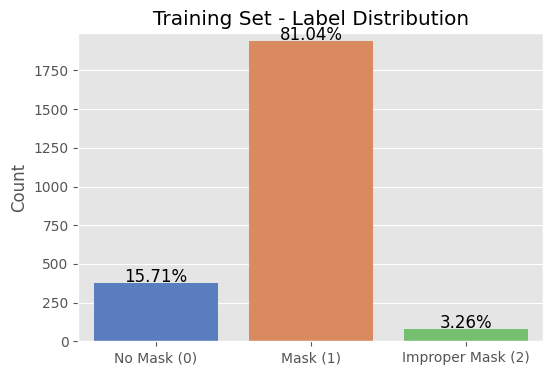

C:\Users\rrahm\AppData\Local\Temp\ipykernel_17220\3863208335.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, ax=ax, palette="muted")


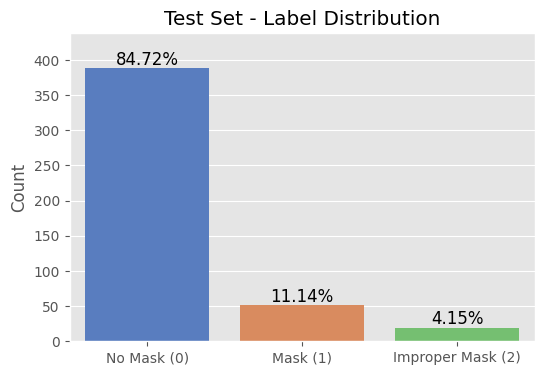

In [4]:
def plotLabelDistribution(labelCounts, title):
    labels = ["No Mask (0)", "Mask (1)", "Improper Mask (2)"]
    values = [labelCounts[0], labelCounts[1], labelCounts[2]]
    percentages = [v / sum(values) * 100 for v in values]

    fig, ax = plt.subplots(figsize=(6, 4))
    sns.barplot(x=labels, y=values, ax=ax, palette="muted")
    
    for i, v in enumerate(values):
        ax.text(i, v + 5, f"{percentages[i]:.2f}%", ha='center', fontsize=12)
    
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.set_ylim(0, max(values) + 50)
    
    plt.show()

# manually entered from notebook 1 results
trainLabelCounts = {0: 376, 1: 1940, 2: 78}
testLabelCounts = {0: 388, 1: 51, 2: 19}

plotLabelDistribution(trainLabelCounts, "Training Set - Label Distribution")
plotLabelDistribution(testLabelCounts, "Test Set - Label Distribution")
